In [15]:
import torch
print(torch.cuda.is_available())  # True
print(torch.cuda.get_device_name(0))  # NVIDIA GeForce RTX 4060

True
NVIDIA GeForce RTX 4060 Laptop GPU


In [16]:
from torchvision import transforms

# Transformaciones para entrenamiento (aumentos + normalización)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Transformaciones para validación y test (solo reescalado + normalización)
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [17]:
import os, math, numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# rutas (según tu estructura)
# lo que tenías (mal): BASE_DIR = os.path.join("002cancer")
BASE_DIR = os.path.join("..", "002_cancer")  # desde /notebooks sube a ../002_cancer
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

# parámetros que me pediste
CLASSES = 2
BATCH   = 32
ROWS = COLS = 224
INPUT_CH = 3
EPOCHS  = 25
TEST_MAX_SAMPLES = 2000
SEED    = 42

# dispositivo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:",DEVICE)
torch.manual_seed(SEED)

Usando dispositivo: cuda


RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit

# Comprobación de carpetas
for p in [TRAIN_DIR, TEST_DIR]:
    assert os.path.isdir(os.path.join(p, "Benign")),    f"Falta {p}/Benign"
    assert os.path.isdir(os.path.join(p, "Malignant")), f"Falta {p}/Malignant"

use_explicit_val = os.path.isdir(VAL_DIR) and all(
    os.path.isdir(os.path.join(VAL_DIR, c)) for c in ["Benign", "Malignant"]
)

from torchvision import datasets
if use_explicit_val:
    train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
    val_ds   = datasets.ImageFolder(VAL_DIR,   transform=val_test_transforms)
else:
    full_train = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
    y = [lbl for _, lbl in full_train.samples]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    train_idx, val_idx = next(sss.split(np.zeros(len(y)), y))
    train_ds = Subset(full_train, train_idx);  train_ds.dataset.transform = train_transforms
    val_ds   = Subset(full_train, val_idx);    val_ds.dataset.transform   = val_test_transforms

test_ds  = datasets.ImageFolder(TEST_DIR, transform=val_test_transforms)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PIN = (DEVICE.type == "cuda")
NUM_WORKERS = 0 if os.name == "nt" else 4

def seed_worker(worker_id):
    import numpy as _np, random as _rand
    _np.random.seed(SEED + worker_id); _rand.seed(SEED + worker_id)

g = torch.Generator(); g.manual_seed(SEED)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN,
                          worker_init_fn=seed_worker, generator=g)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN,
                          worker_init_fn=seed_worker)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN,
                          worker_init_fn=seed_worker)

# Mapeo de clases
if use_explicit_val:
    class_to_idx = datasets.ImageFolder(TRAIN_DIR).class_to_idx
else:
    class_to_idx = train_ds.dataset.class_to_idx if hasattr(train_ds, "dataset") else datasets.ImageFolder(TRAIN_DIR).class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.items()}
print("Clases:", class_to_idx)
print(f"Train={len(train_ds)} | Val={len(val_ds)} | Test={len(test_ds)}")

Clases: {'Benign': 0, 'Malignant': 1}
Train=9504 | Val=2375 | Test=2000


In [ ]:
# ===== Modelo estable con GroupNorm =====
import torch.nn as nn
import math

def _gn_groups(ch):
    # 32 es estándar; si no divide, baja a 16/8/4/1
    for g in [32,16,8,4,1]:
        if ch % g == 0: return g
    return 1

class ConvGNReLU(nn.Sequential):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__(
            nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, bias=False),
            nn.GroupNorm(_gn_groups(out_ch), out_ch),
            nn.ReLU(inplace=True),
        )

class StableCNN(nn.Module):
    def __init__(self, in_ch=3, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            ConvGNReLU(in_ch,   64),
            ConvGNReLU(64,      64),
            nn.MaxPool2d(2),          # 224 -> 112

            ConvGNReLU(64,     128),
            ConvGNReLU(128,    128),
            nn.MaxPool2d(2),          # 112 -> 56

            ConvGNReLU(128,    256),
            ConvGNReLU(256,    256),
            nn.MaxPool2d(2),          # 56 -> 28

            ConvGNReLU(256,    256),
            nn.MaxPool2d(2),          # 28 -> 14
        )
        self.pool = nn.AdaptiveAvgPool2d(1)  # robusto a tamaño
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.30),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.30),
            nn.Linear(128, num_classes)
        )
        self._init()

    def _init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

model = StableCNN(in_ch=INPUT_CH, num_classes=CLASSES).to(DEVICE)
print(model)

BasicCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn.utils import clip_grad_norm_

# Label Smoothing (reduce picos/varianza)
class LabelSmoothingCE(nn.Module):
    def __init__(self, eps=0.05):
        super().__init__()
        self.eps = eps
        self.log_softmax = nn.LogSoftmax(dim=1)
    def forward(self, logits, target):
        n_classes = logits.size(1)
        logprobs  = self.log_softmax(logits)
        nll = nn.functional.nll_loss(logprobs, target, reduction='mean')
        smooth = -logprobs.mean(dim=1).mean()
        return (1 - self.eps) * nll + self.eps * smooth

criterion = LabelSmoothingCE(eps=0.05)

# LR más bajo + weight decay más fuerte
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-4)

# Warmup + Cosine (más suave que ReduceLROnPlateau)
WARMUP_EPOCHS = 3
scheduler_cos = CosineAnnealingLR(optimizer, T_max=max(1, EPOCHS - WARMUP_EPOCHS), eta_min=1e-6)

USE_AMP = (DEVICE.type == "cuda")
scaler  = torch.cuda.amp.GradScaler(enabled=USE_AMP)

def scheduler_step(epoch):
    if epoch < WARMUP_EPOCHS:
        for pg in optimizer.param_groups:
            pg['lr'] = 3e-4 * (epoch + 1) / WARMUP_EPOCHS
    else:
        scheduler_cos.step()

def run_epoch(loader, train_mode=True):
    model.train() if train_mode else model.eval()
    total, correct, running = 0, 0, 0.0

    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        if train_mode:
            optimizer.zero_grad(set_to_none=True)

        if USE_AMP:
            with torch.cuda.amp.autocast():
                logits = model(xb)
                loss   = criterion(logits, yb)
        else:
            logits = model(xb); loss = criterion(logits, yb)

        if train_mode:
            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer); scaler.update()
            else:
                loss.backward()
                clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

        running += loss.item() * xb.size(0)
        pred = logits.argmax(1)
        total += yb.size(0)
        correct += (pred == yb).sum().item()

    return running/total, correct/total

C:\Users\1cnac\AppData\Local\Temp\ipykernel_15792\657509022.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


In [ ]:
# Entrenamiento completo (sin early stopping) guardando histórico
import numpy as np, os

history = {
    "EPOCHS": [],
    "train_loss": [], "val_loss": [],
    "train_acc":  [], "val_acc":  [],
}

# Si ya tienes class_to_idx, omite esto.
try:
    class_to_idx
except NameError:
    from torchvision import datasets
    class_to_idx = datasets.ImageFolder(TRAIN_DIR).class_to_idx

idx_to_class = {v:k for k,v in class_to_idx.items()}
malignant_index = class_to_idx.get("Malignant", 1)  # por si la carpeta se llama distinto, ajusta aquí
print("class_to_idx:", class_to_idx, "| malignant_index:", malignant_index)

class_to_idx: {'Benign': 0, 'Malignant': 1} | malignant_index: 1


In [ ]:
@torch.no_grad()
def evaluate_with_fn(loader):
    model.eval()
    total, correct, running = 0, 0, 0.0
    fn_total = 0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)

        if USE_AMP:
            with torch.cuda.amp.autocast():
                logits = model(xb)
                loss   = criterion(logits, yb)
        else:
            logits = model(xb)
            loss   = criterion(logits, yb)

        running += loss.item() * xb.size(0)
        preds = logits.argmax(1)

        total += yb.size(0)
        correct += (preds == yb).sum().item()

        # FN = verdaderos Malignant predichos como NO-Malignant
        fn_total += ((preds != malignant_index) & (yb == malignant_index)).sum().item()

    return running/total, correct/total, fn_total

In [ ]:
best_val_loss = float("inf")
best_val_fn   = float("inf")
best_path     = "stablecnn_minFN.pt"
# Si NO quieres early stopping, pon patience=None
patience      = None
epochs_no_improve = 0

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train_mode=True)
    va_loss, va_acc, va_fn = evaluate_with_fn(val_loader)

    # scheduler suave
    scheduler_step(epoch)

    # histórico
    history["EPOCHS"].append(epoch)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)

    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.3f} | "
          f"val_loss={va_loss:.4f} acc={va_acc:.3f} | "
          f"val_FN={va_fn} | "
          f"lr={optimizer.param_groups[0]['lr']:.6f}", flush=True)

    # guardar mejor por FN (desempata por menor val_loss)
    improved = (va_fn < best_val_fn) or ((va_fn == best_val_fn) and (va_loss < best_val_loss - 1e-4))
    if improved:
        best_val_fn = va_fn; best_val_loss = va_loss; epochs_no_improve = 0
        torch.save({
            "model_state": model.state_dict(),
            "class_to_idx": class_to_idx,
            "malignant_index": malignant_index,
            "best_val_fn": best_val_fn,
            "best_val_loss": best_val_loss,
            "epoch": epoch
        }, best_path)
        print(f"✔️ Guardado mejor modelo (min FN): FN={best_val_fn}, loss={best_val_loss:.4f} -> {best_path}", flush=True)
    else:
        if patience is not None:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping (sin mejora en FN).", flush=True)
                break

C:\Users\1cnac\AppData\Local\Temp\ipykernel_15792\657509022.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\1cnac\AppData\Local\Temp\ipykernel_15792\316291866.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[01/25] train_loss=0.4519 acc=0.781 | val_loss=0.4025 acc=0.812 | val_FN=206 | LR=0.001000
✔️ Guardado mejor modelo (min FN): FN=206, loss=0.4025 -> basic_cnn_minFN.pt
[02/25] train_loss=0.4108 acc=0.809 | val_loss=0.3842 acc=0.822 | val_FN=161 | LR=0.001000
✔️ Guardado mejor modelo (min FN): FN=161, loss=0.3842 -> basic_cnn_minFN.pt
[03/25] train_loss=0.3820 acc=0.826 | val_loss=0.3651 acc=0.851 | val_FN=207 | LR=0.001000
[04/25] train_loss=0.3676 acc=0.836 | val_loss=0.4325 acc=0.806 | val_FN=368 | LR=0.001000
[05/25] train_loss=0.3565 acc=0.841 | val_loss=0.3370 acc=0.858 | val_FN=167 | LR=0.001000
[06/25] train_loss=0.3371 acc=0.851 | val_loss=0.3150 acc=0.864 | val_FN=144 | LR=0.001000
✔️ Guardado mejor modelo (min FN): FN=144, loss=0.3150 -> basic_cnn_minFN.pt
[07/25] train_loss=0.3266 acc=0.858 | val_loss=0.3072 acc=0.875 | val_FN=158 | LR=0.001000
[08/25] train_loss=0.3179 acc=0.861 | val_loss=0.3376 acc=0.848 | val_FN=106 | LR=0.001000
✔️ Guardado mejor modelo (min FN): FN=106

In [ ]:
ckpt = torch.load("stablecnn_minFN.pt", map_location=DEVICE)
model.load_state_dict(ckpt["model_state"])
class_to_idx = ckpt["class_to_idx"]
malignant_index = ckpt.get("malignant_index", class_to_idx.get("Malignant", 1))
idx_to_class = {v:k for k,v in class_to_idx.items()}
print(f"Mejor modelo cargado | FN={ckpt.get('best_val_fn')} loss={ckpt.get('best_val_loss')}", flush=True)

Mejor modelo cargado desde basic_cnn_minFN.pt | FN=90 loss=0.2966884508383901


C:\Users\1cnac\AppData\Local\Temp\ipykernel_15792\315178369.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_path, map_location=DEVICE)


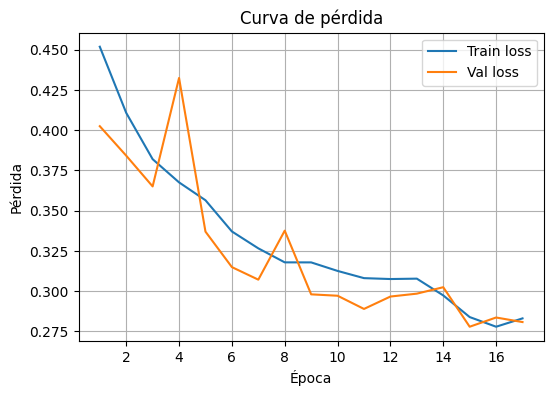

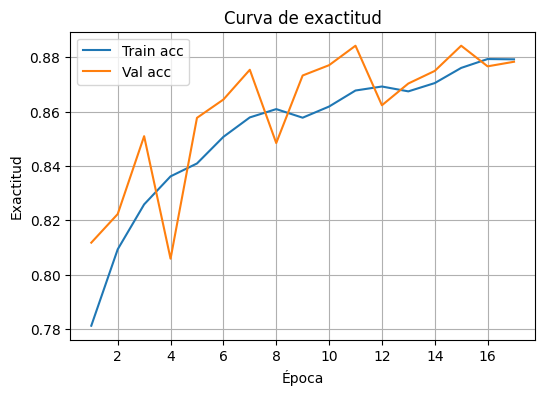

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def smooth(x, k=3):
    import numpy as np
    if len(x) < k: return np.array(x, float)
    x = np.array(x, float)
    return np.convolve(x, np.ones(k)/k, mode="valid")

k = 3
if len(epochs) >= k:
    e2 = epochs[k-1:]
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,4))
    plt.plot(e2, smooth(tr_loss,k), label="Train loss (sm)")
    plt.plot(e2, smooth(val_loss,k), label="Val loss (sm)")
    plt.xlabel("Época"); plt.ylabel("Pérdida"); plt.title("Loss suavizada")
    plt.legend(); plt.grid(True); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(e2, smooth(tr_acc,k), label="Train acc (sm)")
    plt.plot(e2, smooth(val_acc,k), label="Val acc (sm)")
    plt.xlabel("Época"); plt.ylabel("Exactitud"); plt.title("Accuracy suavizada")
    plt.legend(); plt.grid(True); plt.show()

C:\Users\1cnac\AppData\Local\Temp\ipykernel_15792\3731055745.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Test accuracy: 0.8755
              precision    recall  f1-score   support

      Benign       0.91      0.83      0.87      1000
   Malignant       0.84      0.92      0.88      1000

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



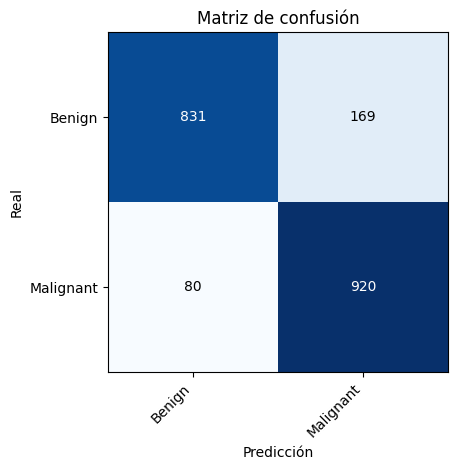

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        if USE_AMP:
            with torch.cuda.amp.autocast():
                logits = model(xb)
        else:
            logits = model(xb)
        pred = logits.argmax(1).cpu()
        all_preds.append(pred)
        all_labels.append(yb)

all_preds  = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

test_acc = (all_preds == all_labels).mean()
print(f"Test accuracy: {test_acc:.4f}")
print(classification_report(all_labels, all_preds,
                            target_names=[idx_to_class[0], idx_to_class[1]]))

cm = confusion_matrix(all_labels, all_preds, labels=[0,1])

plt.figure(figsize=(4.8,4.8))
im = plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Matriz de confusión")
tick_marks = np.arange(2)
plt.xticks(tick_marks, [idx_to_class[0], idx_to_class[1]], rotation=45, ha="right")
plt.yticks(tick_marks, [idx_to_class[0], idx_to_class[1]])
plt.xlabel("Predicción"); plt.ylabel("Real")

th = cm.max()/2.0 if cm.size > 0 else 0.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], "d"),
                 ha="center", va="center",
                 color="white" if cm[i, j] > th else "black")

plt.tight_layout(); plt.show()